In [873]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.fftpack as spfft

%env CUDA_VISIBLE_DEVICES=0
import torch
import torchvision as tv
from torchvision import datasets, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import math

import time

import pywt

env: CUDA_VISIBLE_DEVICES=0


In [874]:
LR = 1e-4 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 10000 # number iterations
WD = 1e-4 # weight decay for l2-regularization

INPUT_LEN = 32 # input len
INPUT_CHANS = 64 #number of channels in our input 

OUTPUT_CHANS = 1 #num channels in the net output
OUTPUT_LEN = 128

X_OUTPUT = np.arange(OUTPUT_LEN) #set up an axis for plotting wave outputs

NUM_MEASUREMENTS = 100

In [875]:
CUDA = torch.cuda.is_available()
#CUDA = False
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


In [876]:
#INPUT_LEN = 32
#Latent size = output for input_chans = 4
class DCGAN(nn.Module):
    def __init__(self, input_chans=32, output_chans=1, num_measurements = 128, output_size = 128):
        super(DCGAN, self).__init__()
        self.nc = output_chans
        self.output_size = output_size
        self.CUDA = CUDA

        #for default case (32 input_chans) - #params = output_len
        #reduce input_chans to underparameterize, increase to overparameterize

        self.conv1 = nn.ConvTranspose1d(input_chans, output_chans, 4, 4, 0, bias=False) #fine filter
        
        self.fc = nn.Linear(output_size * output_chans, num_measurements, bias=False)

    def forward(self, x):
        x = self.conv1(x)

        return x
    
    def measurements(self, x):
        y = self.forward(x).view(1, -1)

        meas = self.fc(y).view(-1, 1)

        if self.CUDA:
            return meas.cuda()
        else:
            return meas

In [877]:
y0 = np.zeros((OUTPUT_LEN, 1))
y0[:,0] = pywt.data.demo_signal(name='Heavisine', n=OUTPUT_LEN)

In [878]:
def get_stats(x):
    a = np.min(x)
    b = np.max(x)
    mu = (a+b)/2.0
    sigma = (b-a)/2.0
    return [mu, sigma]
    #mu = np.mean(x)
    #sigma = np.std(x)
    #return [mu, sigma]

MU = get_stats(y0)[0]
SIGMA = get_stats(y0)[1]

def normalise(x):
    return (x-MU)/SIGMA

def renormalise(x):
    return x*SIGMA + MU

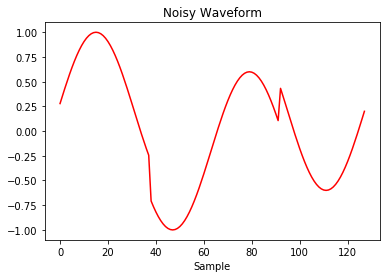

In [879]:
y0 = normalise(y0)
plt.figure()
plt.plot(X_OUTPUT, y0, color='r')
plt.xlabel("Sample")
plt.title("Noisy Waveform")
plt.show()

In [880]:
kept_samples = random.sample(range(0, OUTPUT_LEN), NUM_MEASUREMENTS)
imputed_samples = [z for z in range(0, OUTPUT_LEN) if z not in kept_samples]

A = np.eye(OUTPUT_LEN)[kept_samples, :]
print(A.shape)

y1 = np.dot(A, y0)
print(y1.shape)

(100, 128)
(100, 1)


In [881]:
y = torch.Tensor(y1)
y = Variable(y.type(dtype))

if CUDA:
    y = y.cuda()

In [882]:
net = DCGAN(input_chans = INPUT_CHANS, output_chans = OUTPUT_CHANS, num_measurements=NUM_MEASUREMENTS)
net.fc.requires_grad = False
net.fc.weight.data = torch.Tensor(A)

allparams = [x for x in net.parameters()]
allparams = allparams[:-1]

z = Variable(torch.zeros(INPUT_LEN * INPUT_CHANS).type(dtype).view(1,INPUT_CHANS,INPUT_LEN))
z.data.normal_().type(dtype)
z.requires_grad = False

if CUDA:
    net.cuda()
    print("USING CUDA")
else:
    print("RUNNING ON CPU")

USING CUDA


In [883]:
optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

mse = torch.nn.MSELoss().type(dtype)

9999


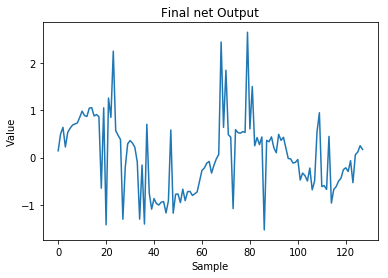

Execution Time:  7.4 s


In [884]:
mse_log_true = np.zeros((NUM_ITER))
mse_log_noisy = np.zeros((NUM_ITER))

start = time.time()

for i in range(NUM_ITER):
    optim.zero_grad()
    out = net(z)
    
    if(i%100 ==0):
    
        awgn = np.zeros((NUM_MEASUREMENTS, 1))
        awgn[:,0] = 0.1 * np.random.randn(NUM_MEASUREMENTS)
    
        y = torch.Tensor(y1 + awgn)
        y = Variable(y.type(dtype))

        if CUDA:
            y = y.cuda()
    
    loss = mse(net.measurements(z), y) 

    wave = out[0].detach().reshape(-1, OUTPUT_CHANS).cpu().numpy()

    mse_log_true[i] = np.mean((np.squeeze(y0)[imputed_samples] - np.squeeze(wave)[imputed_samples])**2)
    mse_log_noisy[i] = np.mean((np.squeeze(y0)[kept_samples] - np.squeeze(wave)[kept_samples])**2)
    
    if i == NUM_ITER - 1:
        print(i)
        
        plt.plot(X_OUTPUT, wave)
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.title("Final net Output")
        plt.show()
    
    loss.backward()
    optim.step()
    
end = time.time()
print("Execution Time: ", round(end-start, 2), "s")

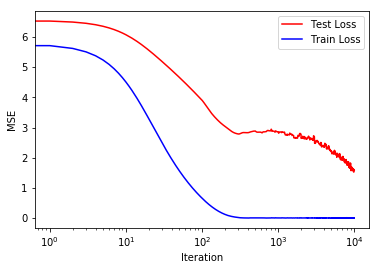

In [885]:
plt.figure()
plt.plot(np.arange(NUM_ITER), mse_log_true, color='r', label='Test Loss')
plt.plot(np.arange(NUM_ITER), mse_log_noisy, color='b', label='Train Loss')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.xscale("log")
#plt.ylim(0, 0.2)
plt.show()